In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
import missingno as msno

from sklearn.metrics import precision_score,recall_score,confusion_matrix,f1_score,accuracy_score,classification_report,ConfusionMatrixDisplay

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Importing the dataset
data = pd.read_csv('/content/drive/MyDrive/Data_driven_decision/fake_job_postings.csv')

<Axes: >

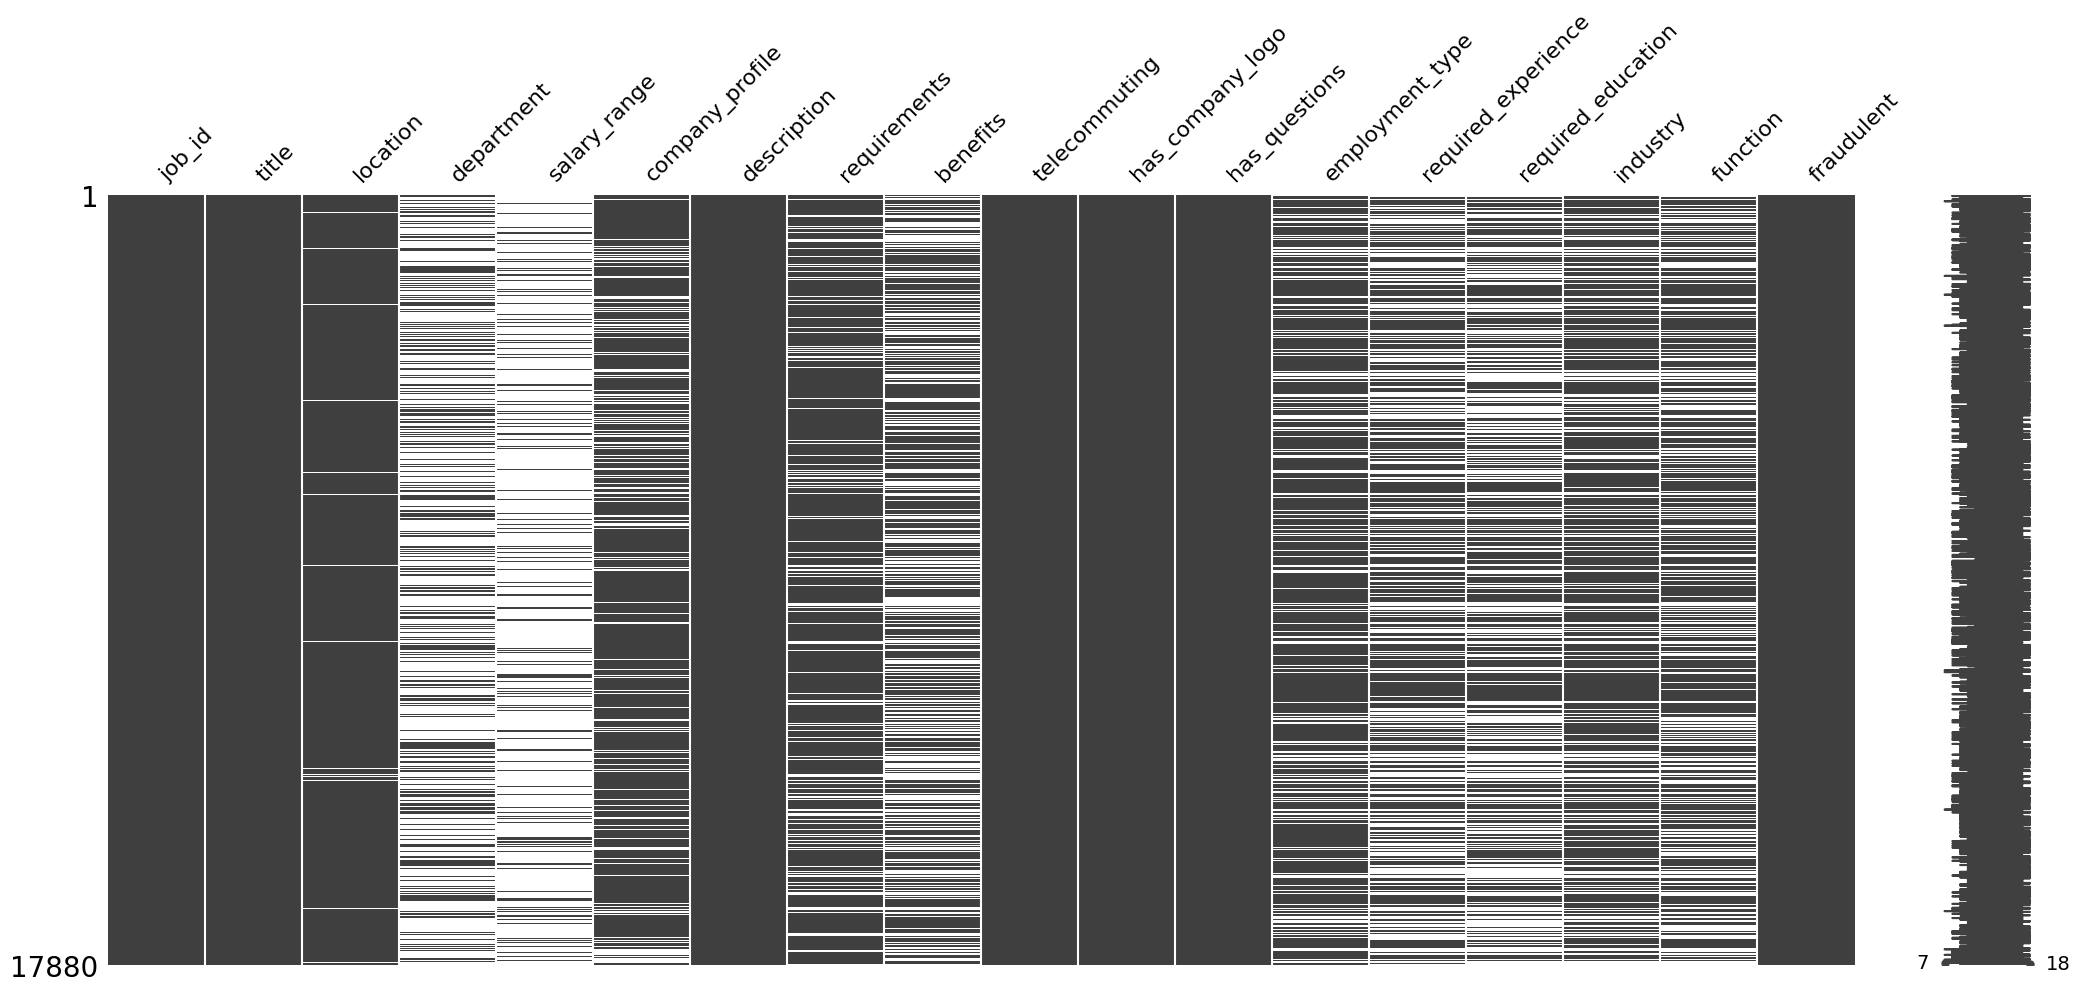

In [ ]:
msno.matrix(data)

In [ ]:
#viewing the dataset
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#checking for the null values
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
#As we have many null values, we are replacing them with the 'Unspecified'
data['location'] = data['location'].fillna('')
data['department'] = data['department'].fillna('Unspecified')
data['salary_range'] = data['salary_range'].fillna('')
data['company_profile'] = data['company_profile'].fillna('Unspecified')
data['requirements'] = data['requirements'].fillna('Unspecified')
data['employment_type'] = data['employment_type'].fillna('Unspecified')
data['required_experience'] = data['required_experience'].fillna('Unspecified')
data['required_education'] = data['required_education'].fillna('Unspecified')
data['industry'] = data['industry'].fillna('Unspecified')
data['function'] = data['function'].fillna('Unspecified')
data['benefits'] = data['benefits'].fillna('Unspecified')

In [ ]:
#Dropping the null values -- It is only due to description column
data.dropna(inplace=True)

In [ ]:
data.isna().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

def preprocess(text):
    text=text.lower()
    text= re.sub("[\\n,\n,\t,\\,\\,$.,#,'\',]", "", text)
    text=re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub("\[.*?\]","", text)#removes . * ?
    text=text.strip()# removes trailing spaces from left and right
    return text

data['company_profile'] = data['company_profile'].apply(lambda text: preprocess(text))
data['description'] = data['description'].apply(lambda text: preprocess(text))
data['requirements'] = data['requirements'].apply(lambda text: preprocess(text))
data['benefits'] = data['benefits'].apply(lambda text: preprocess(text))

In [ ]:
#extracting the country and state from the location column
location = data['location'].apply(lambda x:str(x).strip().split(','))

In [ ]:
#convertint them into series
location = location.apply(pd.Series)
location

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,US,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NZ,,Auckland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,IA,Wever,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,DC,Washington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,FL,Fort Worth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,CA,ON,Toronto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17876,US,PA,Philadelphia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17877,US,TX,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17878,NG,LA,Lagos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#keepinhg the columns having the first 4 columns not null
location[~(location[4].isna())]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
733,US,AL,Birmingham,Montgomery,Atlanta Ga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1725,US,TX,Austin,San Antonio,Houston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4396,US,MI,Hartford,Paw Paw,Lawton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480,US,CA,San Jose,SFO,Austin,OH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4527,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4650,US,FL,Central Fl,Nort Fl,Georgia,Alabama,Tennessee,South Carolina,North Carolina,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11987,US,CA,Los Angeles,Anaheim,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12383,NL,ZH,Rotterdam,The Hague,Utrecht,Amsterdam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12467,US,NJ,Lakewood,Brick,Toms River,Jackson,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13181,US,CA,Los Angeles,California,San Francisco,California,San Jose,California,Manhattan,New York,Las Vegas,Nevada,Phoenix,Arizona,San Diego,California


In [ ]:
#inserting the country and state into the dataframe from location
data['country'] = location[0]
data['state'] = location[1]

In [ ]:
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,US,NY
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,NZ,
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unspecified,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,US,IA
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC
4,5,Bill Review Manager,"US, FL, Fort Worth",Unspecified,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL


In [ ]:
#filling thw blannks with unspecified
data['state'] = data['state'].fillna('Unspecified')

In [ ]:
data.isna().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
country                0
state                  0
dtype: int64

In [ ]:
#salary = data['salary_range'].apply(lambda x: str(x).strip().split('-'))

In [ ]:
#salary = salary.apply(pd.Series)

def int_convert(x):
    try:
        return int(x)
    except:
        return 0
data['salary_lower_bound']=salary[0]
data['salary_lower_bound']=data['salary_lower_bound'].apply(int_convert)
data['salary_upper_bound']=salary[1]
data['salary_upper_bound']=data['salary_upper_bound'].apply(int_convert)

data['avg_salary']=(data['salary_upper_bound']+data['salary_lower_bound'])/2

In [ ]:
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Unspecified,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,US,NY
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,NZ,
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Unspecified,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Unspecified,0,1,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,US,IA
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC
4,5,Bill Review Manager,"US, FL, Fort Worth",Unspecified,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL


In [ ]:
#dropping the location and joib_id as thye are no longer needed
data.drop(['location','job_id'],inplace=True,axis=1)

In [ ]:
#Remove any unwanted characters or symbols: This includes any special characters, punctuations, or numbers that are not relevant to the analysis or modeling.
#Convert all text to lowercase: This ensures that the model does not distinguish between words in uppercase or lowercase.
#Remove HTML tags and URLs: If the text is scraped from the web, it may contain HTML tags and URLs that need to be removed.
def preprocess(text):
    text=text.lower()
    text= re.sub("[\\n,\n,\t,\\,\\,$.,#,'\',]", "", text)
    text=re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub("\[.*?\]","", text)#removes . * ?
    text=text.strip()# removes trailing spaces from left and right
    return text
text_cols = ['title','company_profile','description','requirements','benefits']
for i in text_cols:
  data[i] = data[i].apply(lambda x: preprocess(x))


In [ ]:
#Remove stop words: These are common words like "the", "and", "a", which are not useful in most analyses.
import nltk
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def stopwords_removal(text):
  text = str(text).split()
  return " ".join(word for word in text if word not in stop_words)

#Applying that function for reviewText column using lambda function to remove the stopwords from thre text columns
for i in text_cols:
  data[i] = data[i].apply(lambda x: stopwords_removal(x))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#CHecking the data description
data.description[0]

'food52 fast-growing james beard award-winning online food community crowd-sourced curated recipe hub currently interviewing full- part-time unpaid interns work small team editors executives developers new york city headquartersreproducing and/or repackaging existing food52 content number partner sites huffington post yahoo buzzfeed various content management systemsresearching blogs websites provisions food52 affiliate programassisting day-to-day affiliate program support screening affiliates assisting affiliate inquiriessupporting pr &amp; events neededhelping office administrative work filing mailing preparing meetingsworking developers document bugs suggest improvements sitesupporting marketing executive staff'

In [ ]:
#lemmatizing the words
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  #text = str(text).split()
  tokens = nltk.word_tokenize(text)
  lemm_word = [lemmatizer.lemmatize(token) for token in tokens]
  return " ".join(lemm_word)
for i in text_cols:
  #data[i] = data[i].apply(lambda x:[lemmatizer.lemmatize(word) for word in str(x).split()])
  data[i] = data[i].apply(lambda x: lemmatization(x))

In [ ]:
data.head(5)

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state
0,marketing intern,Marketing,,food52 weve created groundbreaking award-winni...,food52 fast-growing james beard award-winning ...,experience content management system major plu...,unspecified,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,US,NY
1,customer service - cloud video production,Success,,90 second world cloud video production service...,organised - focused - vibrant - awesome ! do p...,expect you : your key responsibility communica...,get usthrough part 90 second team gain : exper...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,NZ,
2,commissioning machinery assistant ( cma ),Unspecified,,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement pre-commissioning commissioning proc...,unspecified,0,1,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,US,IA
3,account executive - washington dc,Sales,,passion improving quality life geography heart...,company : esri – environmental system research...,education : bachelor ’ s master ’ s gi busines...,culture anything corporate—we collaborative cr...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC
4,bill review manager,Unspecified,,spotsource solution llc global human capital m...,job title : itemization review managerlocation...,qualification : rn license state texasdiploma ...,full benefit offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL


In [ ]:
#creating a list called categorical_cols and added all the categorical columns
categorical_cols=['employment_type','required_experience','required_education','industry','function','telecommuting','has_company_logo','has_questions','fraudulent']

In [ ]:
#created a nre column that is hte combination of all the text columns
text_cols = ['title','company_profile','description','requirements','benefits']
data['text']=data['title'] +' '+data['benefits']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']

In [ ]:
#creating a data frame which is holding only fraud valeus
fraud_data = data[data['fraudulent']==1]
non_fraud_data = data[data['fraudulent']==0]

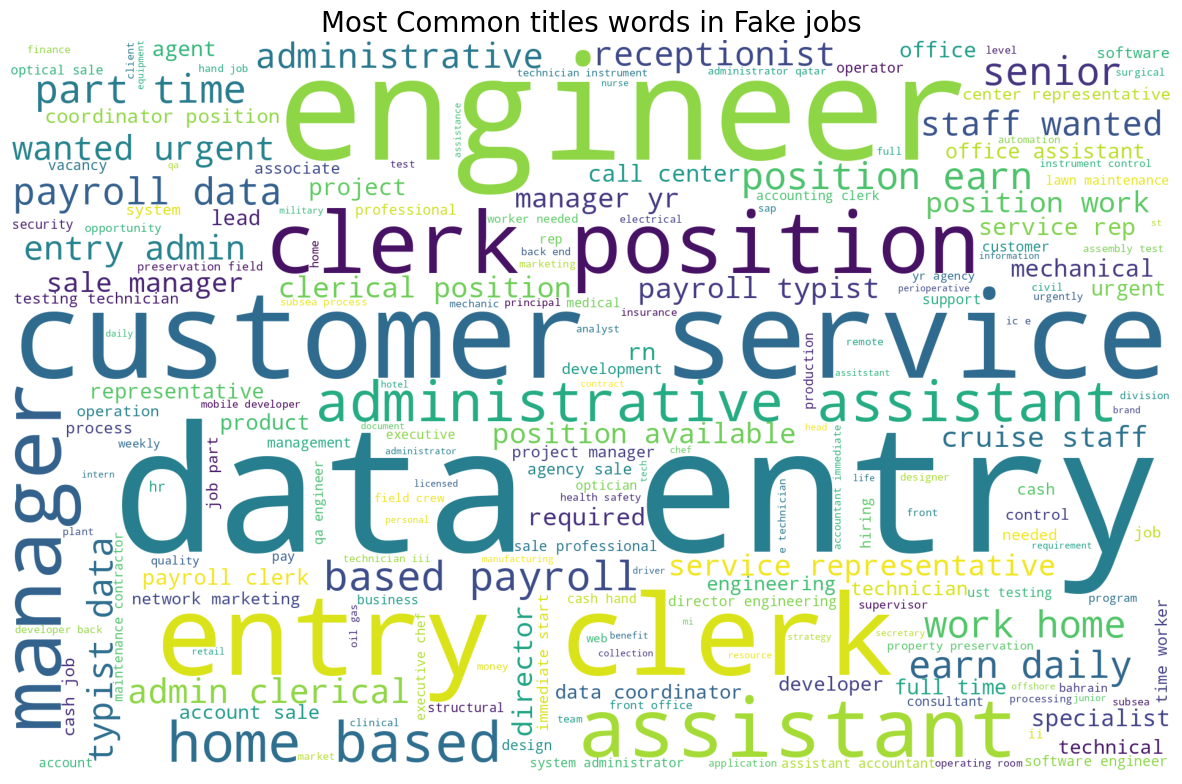

In [ ]:
titles_corpus = fraud_data['title'].values.tolist()
fraud_titles_corpus=' '.join(titles_corpus)
plt.figure(figsize=(15,10))
wordcloudfraud=WordCloud(width = 1900 , height = 1200 , background_color='white').generate(fraud_titles_corpus)
plt.axis('off')
plt.title('Most Common titles words in Fake jobs',size=20)
plt.imshow(wordcloudfraud)

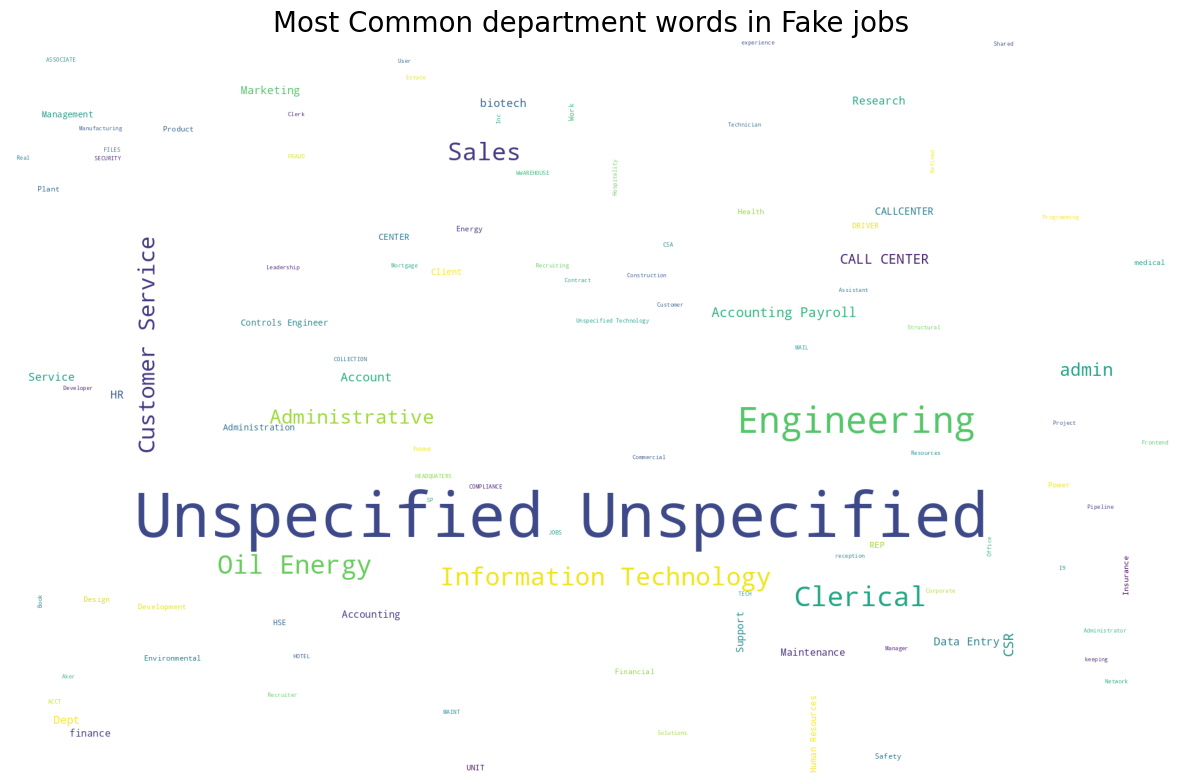

In [ ]:
#creatinf the wordcount figure ti see which job departmetn is mostly appearing in tge fraud dataset
dept_corpus = fraud_data['department'].values.tolist()
fraud_dept_corpus=' '.join(dept_corpus)
plt.figure(figsize=(15,10))
wordcloudfraud=WordCloud(width = 1900 , height = 1200 , background_color='white').generate(fraud_dept_corpus)
plt.axis('off')
plt.title('Most Common department words in Fake jobs',size=20)
plt.imshow(wordcloudfraud)

In [ ]:
#dropping the unwanted columns adnd changing thr postiion of text column
data.drop(['title','benefits','company_profile','description','requirements'],axis=1,inplace=True)
cols = data.columns.tolist()
cols.insert(2, cols.pop(cols.index('text')))
data = data[cols]

In [ ]:
data.head(5)

,department,salary_range,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state
0,Marketing,,marketing intern unspecified food52 weve creat...,0,1,0,Other,Internship,Unspecified,Unspecified,Marketing,0,US,NY
1,Success,,customer service - cloud video production get ...,0,1,0,Full-time,Not Applicable,Unspecified,Marketing and Advertising,Customer Service,0,NZ,
2,Unspecified,,commissioning machinery assistant ( cma ) unsp...,0,1,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,0,US,IA
3,Sales,,account executive - washington dc culture anyt...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC
4,Unspecified,,bill review manager full benefit offered spots...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL


In [ ]:
#intializing the vectorizer and fititng to out ddataste adn transforming our dataset.
vectorizer=TfidfVectorizer(strip_accents='unicode',analyzer='word',ngram_range=(1, 2),max_features=10000,smooth_idf=True,sublinear_tf=True,)
vectorizer.fit(data["text"])
X = vectorizer.transform(data["text"])

In [ ]:
y = data['fraudulent']

In [ ]:
#Splititng the dataset as training adn test
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.30, random_state=31)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12515, 10000), (5364, 10000), (12515,), (5364,))

In [ ]:
#Using GaussianNB model to predict the output
model=GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
x_train_pred = model.predict(X_train)

In [ ]:
print(f"classification_report:\n {classification_report(y_train,x_train_pred)}")

classification_report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     11904
           1       0.82      1.00      0.90       611

    accuracy                           0.99     12515
   macro avg       0.91      0.99      0.95     12515
weighted avg       0.99      0.99      0.99     12515



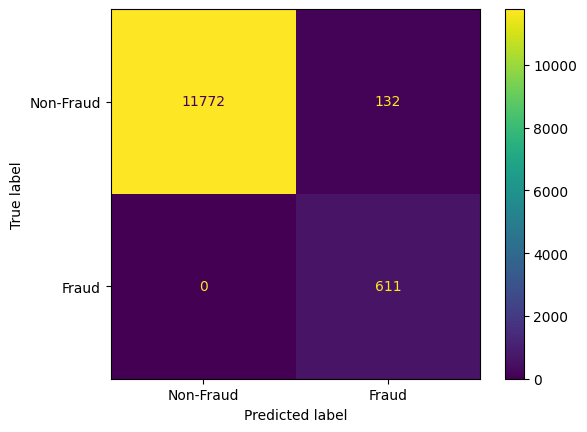

In [ ]:
#plotting the confusion matrix
cf=confusion_matrix(y_train,x_train_pred)
disp = ConfusionMatrixDisplay(cf,display_labels=['Non-Fraud','Fraud'])
disp.plot()
plt.show()

In [ ]:
#printing the classification report to find the metrics
print(f"classification_report:\n {classification_report(y_test,y_pred)}")

classification_report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      5110
           1       0.71      0.67      0.69       254

    accuracy                           0.97      5364
   macro avg       0.85      0.83      0.84      5364
weighted avg       0.97      0.97      0.97      5364



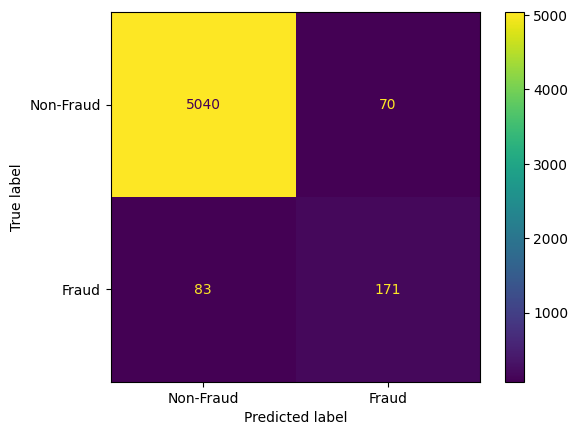

In [ ]:
#plotting the confusion matrix
cf=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cf,display_labels=['Non-Fraud','Fraud'])
disp.plot()
plt.show()

In [ ]:
data['fraudulent'].value_counts()

0    17014
1      865
Name: fraudulent, dtype: int64

In [ ]:
from sklearn.metrics import classification_report
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_report = classification_report(y_train , y_train_pred)
test_report = classification_report(y_test , y_test_pred)


print('Train Report', '\n', train_report)
print('\n'*2)
print('Test Report', '\n', test_report)

Train Report 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     11904
           1       0.82      1.00      0.90       611

    accuracy                           0.99     12515
   macro avg       0.91      0.99      0.95     12515
weighted avg       0.99      0.99      0.99     12515




Test Report 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      5110
           1       0.71      0.67      0.69       254

    accuracy                           0.97      5364
   macro avg       0.85      0.83      0.84      5364
weighted avg       0.97      0.97      0.97      5364



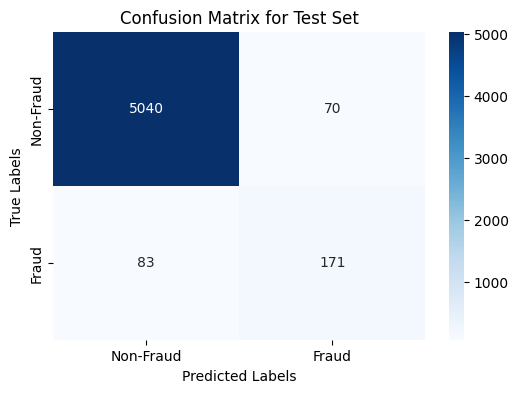

In [ ]:
plt.figure(figsize=(6,4))

conf_matrix = confusion_matrix(y_test, y_test_pred)

sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='g')

plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

labels = ['Non-Fraud', 'Fraud']
plt.xticks(np.arange(len(labels))+0.5, labels)
plt.yticks(np.arange(len(labels))+0.5, labels)

plt.show()

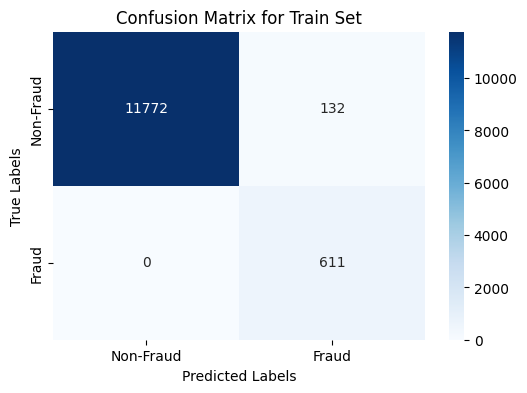

In [ ]:
plt.figure(figsize=(6,4))

conf_matrix = confusion_matrix(y_train , y_train_pred)

sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='g')

plt.title('Confusion Matrix for Train Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

labels = ['Non-Fraud', 'Fraud']
plt.xticks(np.arange(len(labels))+0.5, labels)
plt.yticks(np.arange(len(labels))+0.5, labels)

plt.show()

In [ ]:
fraud_data['department'].value_counts()

Unspecified                                    530
Engineering                                     46
Clerical                                        27
Oil & Energy                                    24
Information Technology                          15
                                              ... 
Administration                                   1
Commercial Management / Contract Management      1
Engineering - Construction                       1
Recruiting                                       1
Sales and Marketing                              1
Name: department, Length: 104, dtype: int64

In [ ]:
fraud_data.head(5)

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,text
98,ic & e technician,Oil & Energy,95000-115000,staffing & amp ; recruiting done right oil & a...,ic & amp ; e technician | bakersfield ca mt po...,qualificationsknowledge skill & amp ; ability ...,benefitswhat offered : competitive compensatio...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,,ic & e technician benefitswhat offered : compe...
144,forward cap,Unspecified,,unspecified,group raised fund purchase home southeast stud...,unspecified,unspecified,0,0,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,1,,Unspecified,forward cap unspecified unspecified group rais...
173,technician instrument & control,Power Plant & Energy,,edison international refined resource partnere...,technician instrument & amp ; controlslocation...,job qualifications-ability understand procedur...,team almost 8000 employee help power almost 40...,0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1,US,Unspecified,technician instrument & control team almost 80...
180,sale executive,Sales,,unspecified,sale executive,sale executive,sale executive,0,0,0,Unspecified,Unspecified,Unspecified,Unspecified,Sales,1,PK,SD,sale executive sale executive unspecified sale...
215,ic & e technician mt poso,Oil & Energy,95000-115000,staffing & amp ; recruiting done right oil & a...,ic & amp ; e technician | bakersfield ca mt po...,qualificationsknowledge skill & amp ; ability ...,benefitswhat offered : competitive compensatio...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,CA,ic & e technician mt poso benefitswhat offered...


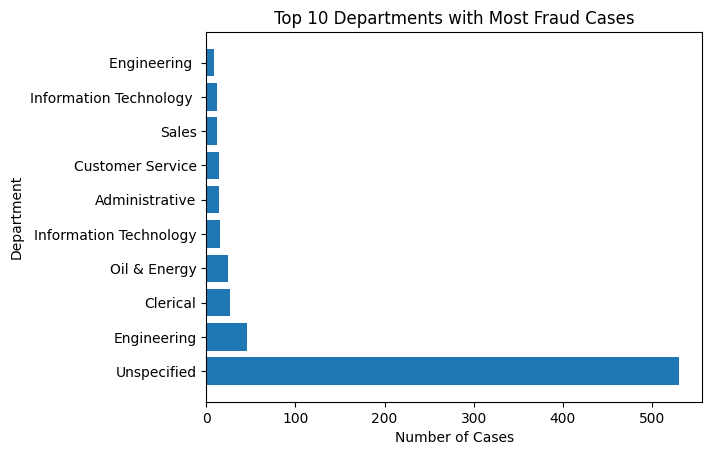

In [ ]:
import matplotlib.pyplot as plt

dept_counts = fraud_data['department'].value_counts().nlargest(10)

plt.barh(dept_counts.index, dept_counts.values)

plt.title('Top 10 Departments with Most Fraud Cases')
plt.xlabel('Number of Cases')
plt.ylabel('Department')

plt.show()


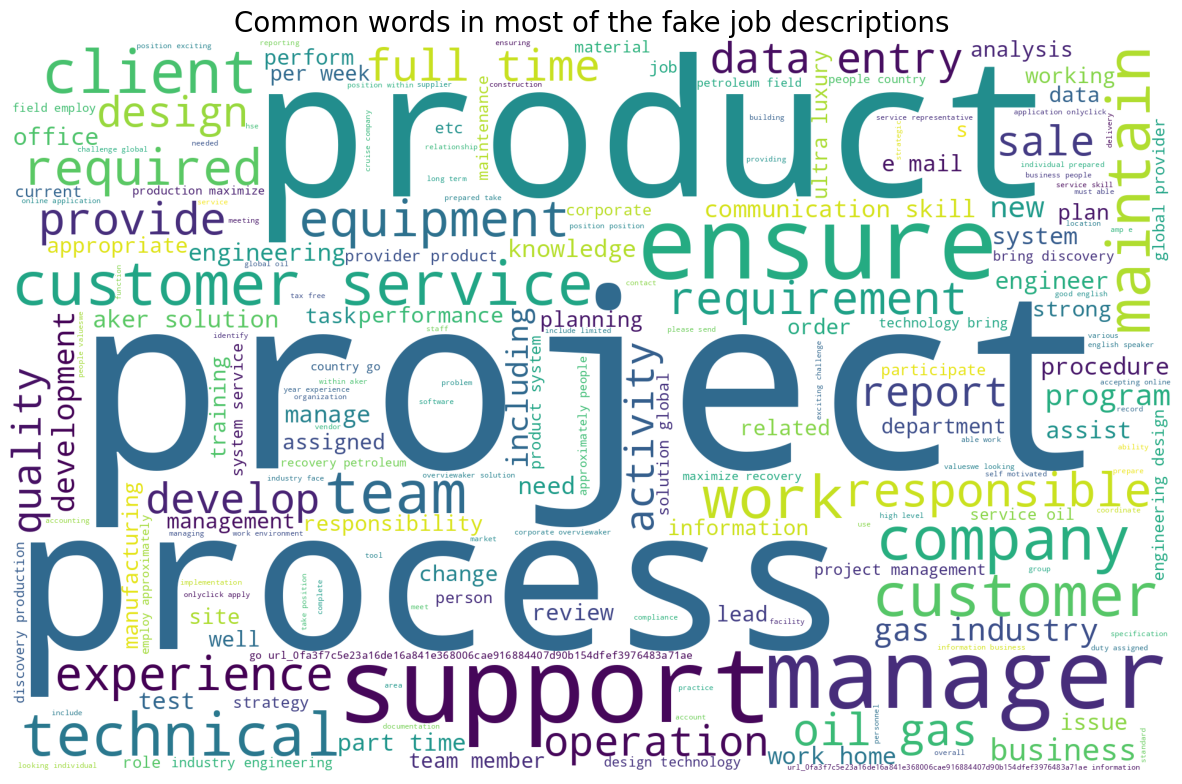

In [ ]:
#creatinf the wordcount figure ti see which job descriptions is mostly appearing in the fraud dataset
dept_corpus = fraud_data['description'].values.tolist()
fraud_dept_corpus=' '.join(dept_corpus)
plt.figure(figsize=(15,10))
wordcloudfraud=WordCloud(width = 1900 , height = 1200 , background_color='white').generate(fraud_dept_corpus)
plt.axis('off')
plt.title('Common words in most of the fake job descriptions',size=20)
plt.imshow(wordcloudfraud)